# Project 02 #

## Anisotropic Diffusion ##

Due: November 12th at 11:59 PM

By: Shane Houghton and Richie Glennon

In [68]:
# Common imports
import numpy as np
import skimage as ski
import skimage.io as io
import matplotlib.pylab as plt
import skimage.filters as filters
plt.gray() # set default to grayscale
import cv2

<Figure size 432x288 with 0 Axes>

**Describe the mathematics behind the filter. Not every equation is necessary, but most should be included, possibly organized in a way to make the code more readable**


$\begin{gather}
I_{s}^{t+1} \approx I_{s}^{t} +\frac{\lambda }{|\eta _{s} |}\sum g\left( |\triangledown I_{s,p}^{t} |, \gamma \right) \triangledown I_{s,p}^{t}\tag{1}\\
\end{gather}$


$\begin{gather}
g( x,\gamma ) =\ \left\{\left[ 1-\left( x^{2} /5\gamma ^{2}\right)\right]^{2} \ where\ |x|\ \leq \ \gamma \sqrt{5} ,\ 0\ otherwise\ \right\}\tag{2}\\
\end{gather}$

Equations source:

https://www.sciencedirect.com/science/article/pii/S147466701642210X

**Describe the purpose of the filter, i.e. what it is used for and what is the output of the filter.**

Anisotropic Diffusion (Perona–Malik diffusion) is an edge preserving noise reduction method. It is an iterative process similar to the blind deconvolution project. The main portion of the process is equation 1 which uses the ESF in equation 2. The process is repeated niter number of times.

**Describe how it works (e.g. first-order edge detectors work because edges are large values in the derivative of the image, but you have to write way more detail)**

**Implementing the filter as a self-contained function taking the image as the first argument and any additional parameters, preferably with reasonable default values.**

In [94]:
def anisotropic_diffusion(im, gamma, lam, niter=10):
    """
    Performs anisotropic diffusion on the given image

    Parameters
    ----------
    * im - the input image to be diffused
    * gam - gamma: positive constant selected according to the smoothing level. should not exceed 1/7
    * lam - lambda: constant related to the diffusion rate

    * niter - (optional): number of iterations 

    Returns
    -------
    imout - the diffused image
    """

    im = ski.img_as_float(im)

    def g(x,y):
        """
        ESF - edge stopping function

        Parameters
        ----------
        * x - gradient
        * y - gamma value
        """

        return np.where(x <= y * np.sqrt(5), (1 - ((x**2)/5*(y**2)))**2, 0)

    h, w = im.shape

    for _ in range(niter):
        im = np.pad(im, 1)
        T = []
        Ip = [
            (slice(None,None), slice(1,None)),
            (slice(None,-1), slice(None,None)),
            (slice(None,None), slice(None,-1)),
            (slice(1,None), slice(None,None)),
        ]

        Is = [
            (slice(None, None), slice(None,-1)),  # 1:h+1, 1:w+1
            (slice(1, None), slice(None, None)),  # :h, 1:w+1
            (slice(None, None), slice(1, None)),  # 1:h+1, :w
            (slice(None, -1), slice(None, None)), # 1:h+1, 1:w+1
        ]
        for (sli1, sli2) in zip(Ip, Is):
            #print(im[sli1])
            gradient = (im[sli1] - im[sli2])[:h, :w]
            T.append(gradient * g(np.abs(gradient), gamma))

        imout = im[1:h+1, 1:w+1] + (lam / 4) * np.dstack(T).sum(2) #eta = 4 because 4 connected
        im = imout

    return imout

In [88]:
Ip = [
(slice(None,None), slice(1,None)), 
(slice(None,-1), slice(None,None)),
(slice(None,None), slice(None,-1)),
(slice(1,None), slice(None,None)),
]

Is = [
(slice(None, None), slice(None,-1)),
(slice(None, 1), slice(None, None)),
(slice(None, None), slice(None, 1)),
(slice(None, -1), slice(None, None)),
]


In [54]:
im = np.arange(9).reshape(3,3)
im

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [56]:
im[Is[0]] - im[Ip[0]]

array([[-1, -1],
       [-1, -1],
       [-1, -1]])

In [46]:
slice??

Init signature: slice(self, /, *args, **kwargs)
Docstring:     
slice(stop)
slice(start, stop[, step])

Create a slice object.  This is used for extended slicing (e.g. a[0:10:2]).
Type:           type
Subclasses:     


**Demonstration of the filter on images of your choosing with different parameter values. If possible, include example of where the filter “fails”.**

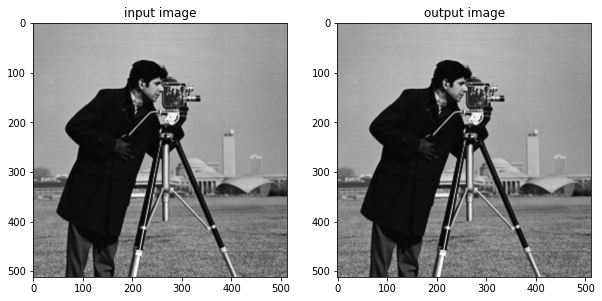

In [97]:
im = io.imread("cameraman.tif")
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(im)
plt.title("input image")
out = anisotropic_diffusion(im, 0.1, 20, niter=100)
plt.subplot(1,2,2)
plt.title("output image") 
plt.imshow(out)

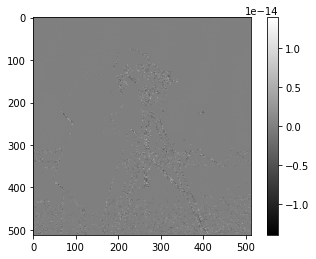

In [99]:
plt.imshow(im/255-out)
plt.colorbar()

**Demonstration of the filter on noisy images (salt and pepper and Gaussian noise), providing recommendations for preprocessing steps to deal with possible noise in images.**

T[0]

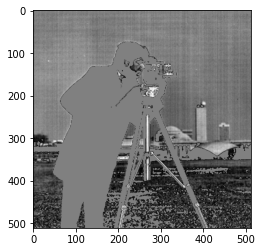

In [86]:
plt.imshow(out[1])